In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Hyperparameters
CURVATURE = -1
DIMENSION = 2
N_SAMPLES = 100

X shape: torch.Size([100, 3])
Dists shape: torch.Size([100, 100])


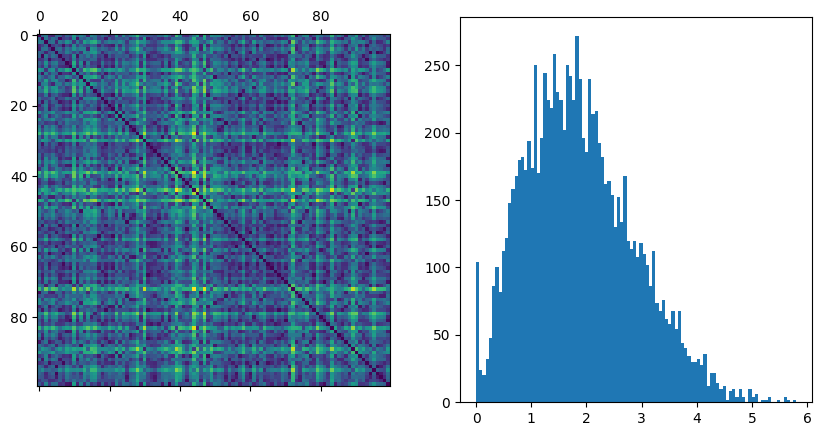

In [3]:
# What is the distribution of deltas for a random manifold?
import torch
import matplotlib.pyplot as plt

from manify.manifolds import ProductManifold

# Initialize product manifold and sample some points
pm = ProductManifold(signature=[(CURVATURE, DIMENSION)])
X, _ = pm.sample(z_mean=torch.stack([pm.mu0] * N_SAMPLES))
print(f"X shape: {X.shape}")

# Get distances
dists = pm.pdist(X)
print(f"Dists shape: {dists.shape}")

# What is the distribution of pairwise distances?
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(dists.detach().cpu().numpy())
axs[1].hist(dists.detach().cpu().numpy().flatten(), bins=100)
plt.show()

Deltas shape: torch.Size([1000])
Max delta: 0.20094001293182373
Ground Delta: (tensor([-3.2690e-01,  3.6863e-02, -1.6871e-01,  1.0491e-01, -2.4239e-01,
        -9.8316e-02,  0.0000e+00,  4.2312e-02,  4.3883e-02, -7.4816e-02,
         2.1891e-02,  1.4848e-03, -1.5564e-02, -3.5127e-03, -1.5801e-01,
        -4.3697e-01,  2.6270e-02, -2.0457e-01, -6.2656e-02, -3.9109e-02,
         1.7773e-02, -6.8797e-02,  7.1111e-02,  1.5280e-02, -8.7994e-02,
        -1.8019e-03, -8.9308e-02,  2.4227e-02, -1.0441e-01,  1.2092e-02,
        -2.6375e-02, -3.3259e-01,  3.5030e-02,  1.6515e-02,  1.3154e-01,
        -5.9124e-02, -2.3193e-01, -6.1298e-02, -7.1623e-02, -1.3791e-01,
         0.0000e+00, -3.4657e-01, -1.8621e-01, -1.3220e-01, -5.8055e-01,
        -3.2655e-02, -6.9317e-02, -2.2651e-03, -2.6204e-01, -1.5983e-02,
        -3.4990e-02,  1.2013e-01,  7.9468e-02, -8.2600e-03,  1.0566e-01,
        -7.9079e-02,  6.3453e-03, -3.9932e-02,  1.2243e-02, -1.4780e-01,
        -1.3187e-03, -1.2189e-01,  9.7983e-03

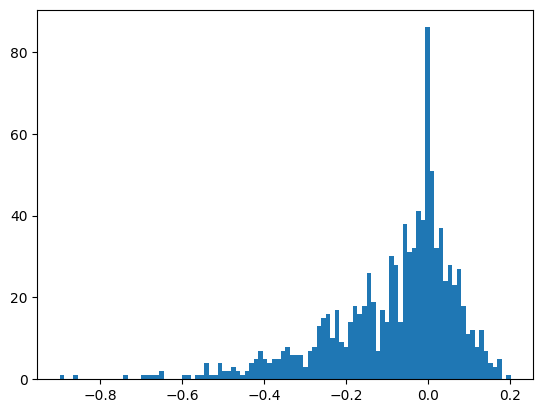

In [12]:
# What is the distribution of deltas?
from manify.curvature_estimation.delta_hyperbolicity import sampled_delta_hyperbolicity

D_FUNC = sampled_delta_hyperbolicity

deltas = D_FUNC(dists)[0]
delta_actual = delta_hyperbolicity(dists)
print(f"Deltas shape: {deltas.shape}")  # TODO: this should be N x N x N, I believe - we need to find the other N
print(f"Max delta: {deltas.max().item()}")
print(f'Ground Delta: {delta_actual}')

plt.hist(deltas.detach().cpu().numpy().flatten(), bins=100)
plt.show()

In [15]:
# Experiment 1: How does delta change with curvature?

import seaborn as sns
import numpy as np

# Thought: re-sampling different manifolds is gonna take a lot of time and also introduce stochasticity.
# Instead, we can use the exponenital map for a single sample.

Ks = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0]
Ks = np.linspace(-3.0, 0.0, 15).tolist()

# Get a single sample
N = torch.distributions.MultivariateNormal(loc=torch.zeros(DIMENSION), covariance_matrix=torch.eye(DIMENSION))

# Get a single sample and raise to tangent plane (prepend with zero)
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

all_deltas = []
ground_deltas = []
full_deltas = []
for K in Ks:
    print(f"Curvature: {K}")
    pm_K = ProductManifold(signature=[(K, DIMENSION)])

    # Get the exponential map
    if K == 0.0:
        x_exp = x
    else:
        x_exp = pm_K.expmap(x_tangent)

    # Get the distance
    dists = pm_K.pdist(x_exp)
    deltas = D_FUNC(dists)
    ground_deltas.append(delta_hyperbolicity(dists).item())
    full_deltas.append(deltas.max().item())

    all_deltas.append(deltas)
print(f'Ground deltas: {ground_deltas}')
print(f'Full delta maxs: {full_deltas}')

# Make seaborn kdeplots for each curvature
colors = sns.color_palette("husl", len(Ks))
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Curvature: {Ks[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different curvatures")
plt.legend()
plt.show()

Curvature: -3.0


AttributeError: 'tuple' object has no attribute 'item'

In [ ]:
# Exp 1 con't: Mean vs Max values for various curvatures

Actuals = [deltas.max().item() for deltas in all_deltas]
Means = [deltas.mean().item() for deltas in all_deltas]

print(f'Delta means: {Means}')
print(f'Actuals: {Actuals}')


plt.plot(Ks,Actuals, label="Actuals")
plt.plot(Ks,Means, label="Means")
plt.xlabel('Curvature')
plt.ylabel('Delta Values')
plt.legend()
plt.show()

In [ ]:
# Digression: is there a monotonic relationship between pairwise distances across curvatures?
# I guess there isn't

K1 = -2.0
K2 = -0

pm1 = ProductManifold(signature=[(K1, DIMENSION)])
pm2 = ProductManifold(signature=[(K2, DIMENSION)])

# Get a single sample
N = torch.distributions.MultivariateNormal(loc=torch.zeros(DIMENSION), covariance_matrix=torch.eye(DIMENSION))

# Get a single sample and raise to tangent plane (prepend with zero)
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

dists1 = pm1.pdist(pm1.expmap(x_tangent))
dists2 = pm2.pdist(pm2.expmap(x_tangent))

# Let's color by the max norm of the points in dists1
max_norms1 = pm1.dist(pm1.expmap(x_tangent), pm1.mu0)
max_norms2 = pm2.dist(pm2.expmap(x_tangent), pm2.mu0)
max_pairwise_norms = torch.max(max_norms1[:, None], max_norms2[None, :]).squeeze()

plt.scatter(
    dists1.detach().cpu().numpy().flatten(),
    dists2.detach().cpu().numpy().flatten(),
    alpha=0.1,
    c=max_pairwise_norms.detach().cpu().numpy(),
)
plt.xlabel(f"Distance, K = {K1}")
plt.ylabel(f"Distance, K = {K2}")
plt.colorbar()
plt.title("Distance between points on different manifolds")

In [ ]:
# Experiment 2: How does delta change with dimension?

# For this one, we can try to truncate a large sample

dims = [2, 4, 8, 16, 32, 64, 128]

N = torch.distributions.MultivariateNormal(loc=torch.zeros(max(dims)), covariance_matrix=torch.eye(max(dims)))

# Get a single sample
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

all_deltas = []
for dim in dims:
    pm_d = ProductManifold(signature=[(CURVATURE, dim)])

    # Get the distance
    dists = pm.pdist(pm.expmap(x_tangent[:, : dim + 1]))
    deltas = D_FUNC(dists)

    all_deltas.append(deltas)

# KDE plot
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Dimension: {dims[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different dimensions")
plt.legend()
plt.show()

In [ ]:
# Experiment 3: How does delta change with sample size?

sample_sizes = [10, 20, 50, 100, 200, 500, 1000]

N = torch.distributions.MultivariateNormal(loc=torch.zeros(max(dims)), covariance_matrix=torch.eye(max(dims)))

# Get a single sample
x = N.sample(sample_shape=(max(sample_sizes),))
x_tangent = torch.hstack([torch.zeros(max(sample_sizes), 1), x])

all_deltas = []
for sample_size in sample_sizes:
    pm_d = ProductManifold(signature=[(CURVATURE, DIMENSION)])

    # Get the distance
    dists = pm.pdist(pm.expmap(x_tangent[:sample_size]))
    deltas = D_FUNC(dists)

    all_deltas.append(deltas)

# KDE plot
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Sample size: {sample_sizes[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different sample sizes")
plt.legend()
plt.show()

## Counter Examples